In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.collab import *
from fastai.tabular import *

from fastai.vision import *
import pandas as pd
import numpy as np

import pdb

### Data set

In [3]:
path = Path('/home/fvadell/trabajo/recs/ml-latest-small')
path.ls()

[PosixPath('/home/fvadell/trabajo/recs/ml-latest-small/links.csv'),
 PosixPath('/home/fvadell/trabajo/recs/ml-latest-small/README.txt'),
 PosixPath('/home/fvadell/trabajo/recs/ml-latest-small/ratings.csv'),
 PosixPath('/home/fvadell/trabajo/recs/ml-latest-small/movies.csv'),
 PosixPath('/home/fvadell/trabajo/recs/ml-latest-small/tags.csv')]

In [4]:
ratings = pd.read_csv(path/'ratings.csv')
ratings['y'] = ratings.rating.apply(str)
ratings['user'] = ratings['userId'].apply(lambda x:str(int(x))).astype('category')
ratings['item'] = ratings['movieId'].apply(lambda x:str(int(x))).astype('category')
ratings.head()

,userId,movieId,rating,timestamp,y,user,item
0,1,1,4.0,964982703,4.0,1,1
1,1,3,4.0,964981247,4.0,1,3
2,1,6,4.0,964982224,4.0,1,6
3,1,47,5.0,964983815,5.0,1,47
4,1,50,5.0,964982931,5.0,1,50


### Mini EDA

In [7]:
# (Cantidad de users, Cantidad de películas)
ratings.userId.unique().shape[0],ratings.movieId.unique().shape[0]

(610, 9724)

In [8]:
ratings.rating.value_counts()

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

In [9]:
print("Cantidad de ratings: ", ratings.rating.shape[0])

Cantidad de ratings:  100836


In [10]:
print("Accuracy base: ", 26818 / 100836)

Accuracy base:  0.2659566028005871


### Definición y entrenamiento del modelo

In [11]:
# Por default toma user, item y rating en la primer, segunda y tercer columna respectivamente
data = CollabDataBunch.from_df(ratings[['userId','movieId','rating']], valid_pct = 0.1)

In [12]:
# cuando se crea el DataBunch pierdo la columna de timestamp
data.show_batch()

userId,movieId,target
608,1274,4.0
440,1093,3.0
448,127319,1.5
64,355,2.5
64,3175,3.5


In [13]:
emb_szs = {
  "userId": 50,
  "movieId": 100,
}

In [14]:
#data = CollabDataBunch.from_df(ratings[['user','movieId','rating']], valid_pct = 0.1)
y_range = [0, 5.5]
learn_small = collab_learner(data, emb_szs=emb_szs, 
                             use_nn = True, emb_drop= .3, 
                             layers = [50, 10, 10], 
                             y_range=y_range)

In [15]:
learn_small.metrics=[r2_score]

### Callbacks

##### Vemos la estructura de un Callback

In [20]:
Callback??

##### Vemos el fit

In [21]:
fit??

In [19]:
loss_batch??

In [19]:
callbacks.EarlyStoppingCallback??

##### Modificación del Early Stopping

In [13]:
class EarlyStoppingFede(callbacks.TrackerCallback):
    valid_track = []
    "A `TrackerCallback` that terminates training when monitored quantity stops improving."
    def __init__(self, learn:Learner, monitor:str='valid_loss', mode:str='auto', min_delta:int=0, patience:int=0):
        super().__init__(learn, monitor=monitor, mode=mode)
        self.min_delta,self.patience = min_delta,patience
        if self.operator == np.less:  self.min_delta *= -1

    def on_train_begin(self, **kwargs:Any)->None:
        "Initialize inner arguments."
        self.wait = 0
        self.valid_track = []
        super().on_train_begin(**kwargs)

    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        "Compare the value monitored to its best score and maybe stop training."
        current = self.get_monitor_value()
        if current is None: return
        self.valid_track.append(current)
        print("")
        print("current: ", current)
        print("current - delta: ", current - self.min_delta)
        print("best: ", self.best)
        if self.operator(current - self.min_delta, self.best):
            self.best,self.wait = current,0
            print("Esto viene bien...")
        else:
            self.wait += 1
            print("Hmmmm... sigamos un poco...")
            if self.wait > self.patience:
                print(f'Epoch {epoch}: early stopping')
                print("Bueno, ya!")
                return {"stop_training":True}
            
    def on_train_end(self, **kwargs:Any)->None:
        "Useful for cleaning up things and saving files/models."
        print(" ")
        plt.plot(self.valid_track)
        plt.grid()
        plt.xlabel("Epoch")
        plt.ylabel("Validation loss")

##### Custom Callback

In [20]:
class TestCallback(Callback):
    def __init__(self, learn: Learner):
        super().__init__()
        self.learn = learn
    
    def on_train_begin(self, **kwargs:Any)->None:
        super().on_train_begin(**kwargs)
        self.n_iters = 0
        #pdb.set_trace()
        
    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        self.n_iters += 1
        print("testCb: Fin de la epoch " ,self.n_iters)
        if self.n_iters>=10: self.learn.stop = True
            
    def on_train_end(self, **kwargs:Any)->None:
        print(" ")
        print("TestCallBack: ¡Gracias por todo! Cantidad de epochs corridas: ", self.n_iters)

In [21]:
testCb = TestCallback(learn = learn_small)
earlyFede = EarlyStoppingFede(learn_small, min_delta = 0.005, patience = 3)

## Modelo de Red Neuronal Collaborative Filtering

##### Entrenamos el modelo

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 6.31E-02


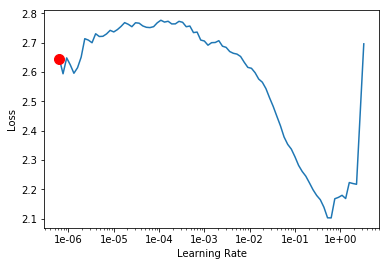

In [22]:
learn_small.lr_find()
learn_small.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,r2_score,time
0,0.851832,0.800809,0.240727,00:19
1,0.816522,0.772397,0.266489,00:27
2,0.786619,0.772206,0.269429,00:33
3,0.738060,0.764302,0.274771,00:35
4,0.753731,0.806135,0.231747,00:37
5,0.779841,0.788304,0.253358,00:38
6,0.804320,0.764049,0.273678,00:41



current:  0.8008087
current - delta:  0.8058087277412415
best:  inf
Esto viene bien...
testCb: Fin de la epoch  1

current:  0.77239716
current - delta:  0.7773971605300903
best:  0.8008087
Esto viene bien...
testCb: Fin de la epoch  2

current:  0.772206
current - delta:  0.7772060084342957
best:  0.77239716
Hmmmm... sigamos un poco...
testCb: Fin de la epoch  3

current:  0.76430184
current - delta:  0.7693018364906311
best:  0.77239716
Esto viene bien...
testCb: Fin de la epoch  4

current:  0.8061351
current - delta:  0.8111351180076599
best:  0.76430184
Hmmmm... sigamos un poco...
testCb: Fin de la epoch  5

current:  0.78830373
current - delta:  0.7933037328720093
best:  0.76430184
Hmmmm... sigamos un poco...
testCb: Fin de la epoch  6

current:  0.76404935
current - delta:  0.7690493512153626
best:  0.76430184
Hmmmm... sigamos un poco...
testCb: Fin de la epoch  7

current:  0.7708403
current - delta:  0.7758402872085571
best:  0.76430184
Hmmmm... sigamos un poco...
Epoch 7: ea

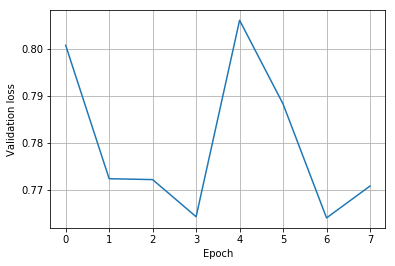

In [23]:
learn_small.fit_one_cycle(20, 6.31E-02, callbacks = [earlyFede, testCb])

##### Predicciones

In [24]:
predicciones_small = learn_small.get_preds(ds_type=DatasetType.Valid)

In [25]:
def create_pred_df(valid_ds, predicciones):
    aux = []
    count = 0
    for user_movie,valor,predic in zip(data.valid_ds.x,
                                       data.valid_ds.y,
                                       predicciones[0].tolist()):
        userId = str(user_movie).split(";")[0][7:]
        movieId = str(user_movie).split(";")[1][9:]
        aux.append([userId, movieId, float(str(valor)), predic[0]])
        count = count +1
    df = pd.DataFrame(aux)
    df.columns = ["userId", "movieId", "rating", "pred"]
    return df

In [26]:
preds_df_small = create_pred_df(data.valid_ds, predicciones_small)
#df['c'] = df.apply(lambda row: row.a + row.b, axis=1)
preds_df_small['error'] = preds_df_small.apply(lambda row: row.pred - row.rating, axis=1)
preds_df_small.head()

,userId,movieId,rating,pred,error
0,610,5377,3.5,4.011244,0.511244
1,474,4002,3.0,3.479929,0.479929
2,140,47099,3.5,4.060600,0.560600
3,489,3408,3.0,3.113737,0.113737
4,599,3250,2.0,2.709454,0.709454


In [27]:
def errors_acum(df, th, inverse = False):
    if (inverse):
        return len(df[df['error']>th])+len(df[df['error']<-th])
    return len(df[(df['error']<=th)&(df['error']>=-th)])

In [28]:
def errors(acums, l):
    stats = {
        '<0.25': acums['<0.25']*100//l,
        '<0.5': (acums['<0.5']-acums['<0.25'])*100//l,
        '<1': (acums['<1']-acums['<0.5'])*100//l,
        '<1.5': (acums['<1.5']-acums['<1'])*100//l,
        '<2': (acums['<2']-acums['<1.5'])*100//l,
        '>2': acums['>2']*100//l
    }
    return stats

In [29]:
acums = {
    '<0.25': errors_acum(preds_df_small, 0.25),
    '<0.5': errors_acum(preds_df_small, 0.5),
    '<1': errors_acum(preds_df_small, 1),
    '<1.5': errors_acum(preds_df_small, 1.5),
    '<2': errors_acum(preds_df_small, 2),
    '>2': errors_acum(preds_df_small,2,inverse=True)
}
stats = errors(acums, len(preds_df_small))

{'<0.25': 22, '<0.5': 21, '<1': 30, '<1.5': 16, '<2': 6, '>2': 3}


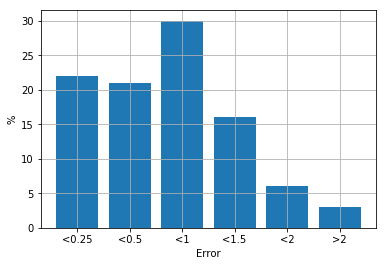

In [62]:
import matplotlib.pyplot as plt

plt.bar(range(len(stats)), list(stats.values()), align='center')
plt.xticks(range(len(stats)), list(stats.keys()))
plt.xlabel('Error')
plt.grid()
plt.ylabel('%')
print(stats)

## Modelo de Red Neuronal Collaborative Filtering

In [76]:
#me armo un validation set. Llamo "lista" a los índices del validation set

#ratings.shape[0] es la cantidad de datos

lista = list(ratings.sample(int(ratings.shape[0]*.10)).reset_index()['index'])

In [77]:
data_tab = TabularDataBunch.from_df('.',ratings[['user','item','y']],
                 cat_names=['user','item'],
                 dep_var='y', valid_idx = lista)

In [78]:
data_tab.show_batch()

user,item,target
516,4291,3.0
125,223,5.0
357,3549,4.5
522,1371,4.0
332,92938,2.0


##### Definimos una red neuronal con la misma cantidad de capas y tamaño de embeddings pero tabular

In [79]:
emb_szs_str = {
  "user": 50,
  "item": 100,
}

In [80]:
learn_tab = tabular_learner(data_tab, layers=[50, 10, 10], emb_szs=emb_szs_str, metrics=accuracy)

In [81]:
learn_tab.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(611, 50)
    (1): Embedding(9725, 100)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=150, out_features=50, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=50, out_features=10, bias=True)
    (4): ReLU(inplace=True)
    (5): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=10, out_features=10, bias=True)
    (7): ReLU(inplace=True)
    (8): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=10, out_features=10, bias=True)
  )
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-01
Min loss divided by 10: 1.32E-01


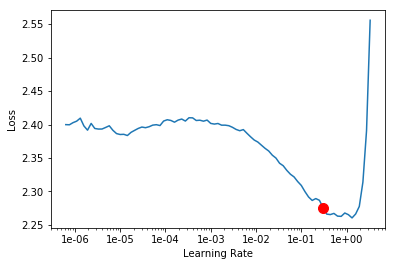

In [82]:
learn_tab.lr_find()
learn_tab.recorder.plot(suggestion=True)

##### Instanciamos otro early stopping pero esta vez para que monitoree el accuracy. Si no aclaramos nada va a monitorear el valid loss, que en este caso es Cross Entropy

In [83]:
earlyFede_tab = EarlyStoppingFede(learn_tab, min_delta = 0.0005, patience = 3, monitor = "accuracy")

epoch,train_loss,valid_loss,accuracy,time
0,1.583642,1.661954,0.337697,00:30
1,1.583573,1.646310,0.343152,00:31
2,1.528782,1.639199,0.338590,00:31
3,1.527014,1.631655,0.352375,00:40
4,1.526486,1.630582,0.345730,00:34
5,1.492037,1.662907,0.343945,00:40
6,1.479680,1.668861,0.345532,00:37



current:  tensor(0.3377)
current - delta:  tensor(0.3372)
best:  -inf
Esto viene bien...
testCb: Fin de la epoch  1

current:  tensor(0.3432)
current - delta:  tensor(0.3427)
best:  tensor(0.3377)
Esto viene bien...
testCb: Fin de la epoch  2

current:  tensor(0.3386)
current - delta:  tensor(0.3381)
best:  tensor(0.3432)
Hmmmm... sigamos un poco...
testCb: Fin de la epoch  3

current:  tensor(0.3524)
current - delta:  tensor(0.3519)
best:  tensor(0.3432)
Esto viene bien...
testCb: Fin de la epoch  4

current:  tensor(0.3457)
current - delta:  tensor(0.3452)
best:  tensor(0.3524)
Hmmmm... sigamos un poco...
testCb: Fin de la epoch  5

current:  tensor(0.3439)
current - delta:  tensor(0.3434)
best:  tensor(0.3524)
Hmmmm... sigamos un poco...
testCb: Fin de la epoch  6

current:  tensor(0.3455)
current - delta:  tensor(0.3450)
best:  tensor(0.3524)
Hmmmm... sigamos un poco...
testCb: Fin de la epoch  7

current:  tensor(0.3461)
current - delta:  tensor(0.3456)
best:  tensor(0.3524)
Hmmm

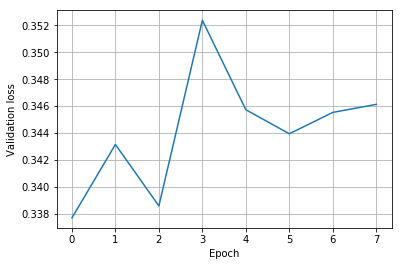

In [85]:
learn_tab.fit_one_cycle(20, 1.32E-02, callbacks = [earlyFede_tab, testCb])

In [151]:
learn_tab.save('Learn_tabWeights')

In [145]:
n=0
q=0
x,y = learn_tab.get_preds(ds_type=DatasetType.Valid)
preds_df_tab = pd.DataFrame(columns=['rating', 'pred', 'error'])

for k,u in enumerate(x.argmax(dim=1)):
    predigo,era = learn_tab.data.classes[u],learn_tab.data.classes[y[k].item()]
    #print(predigo,era)
    error=abs(float(predigo)-float(era))
    aux = [era, predigo, error]
    #print(aux)
    preds_df_tab.loc[k]=aux
    #q+=(float(predigo)-float(era))*(float(predigo)-float(era))
#n=n/y.shape[0]
#q=q/y.shape[0]
print(n)
#print(q)

0


In [161]:
preds_df_tab.head()

,rating,pred,error
0,2.0,2.0,0.0
1,4.0,5.0,1.0
2,5.0,5.0,0.0
3,3.5,2.0,1.5
4,4.5,4.0,0.5


In [162]:
acums_tab = {
    '<0.25': errors_acum(preds_df_tab, 0.26),
    '<0.5': errors_acum(preds_df_tab, 0.51),
    '<1': errors_acum(preds_df_tab, 1.1),
    '<1.5': errors_acum(preds_df_tab, 1.51),
    '<2': errors_acum(preds_df_tab, 2.1),
    '>2': errors_acum(preds_df_tab,2,inverse=True)
}
stats_tab = errors(acums_tab, len(preds_df_tab))

In [163]:
stats_tab

{'<0.25': 34, '<0.5': 25, '<1': 26, '<1.5': 4, '<2': 5, '>2': 3}

{'<0.25': 34, '<0.5': 25, '<1': 26, '<1.5': 4, '<2': 5, '>2': 3}


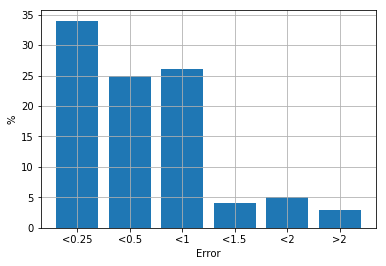

In [164]:
import matplotlib.pyplot as plt

plt.bar(range(len(stats_tab)), list(stats_tab.values()), align='center')
plt.xticks(range(len(stats_tab)), list(stats_tab.keys()))
plt.xlabel('Error')
plt.grid()
plt.ylabel('%')
print(stats_tab)